In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 05: Processos Gaussianos para regressão

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

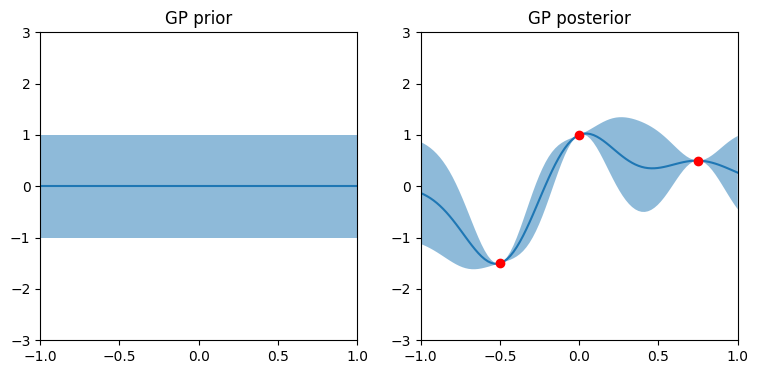

In [2]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')

xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)
    
    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')
plt.show()

Vamos ver como alterar $\gamma$ e $c$ afetam os gráficos, sabendo que esses parâmetros controlam a escala e amplitude da função de covariância, respectivamente:

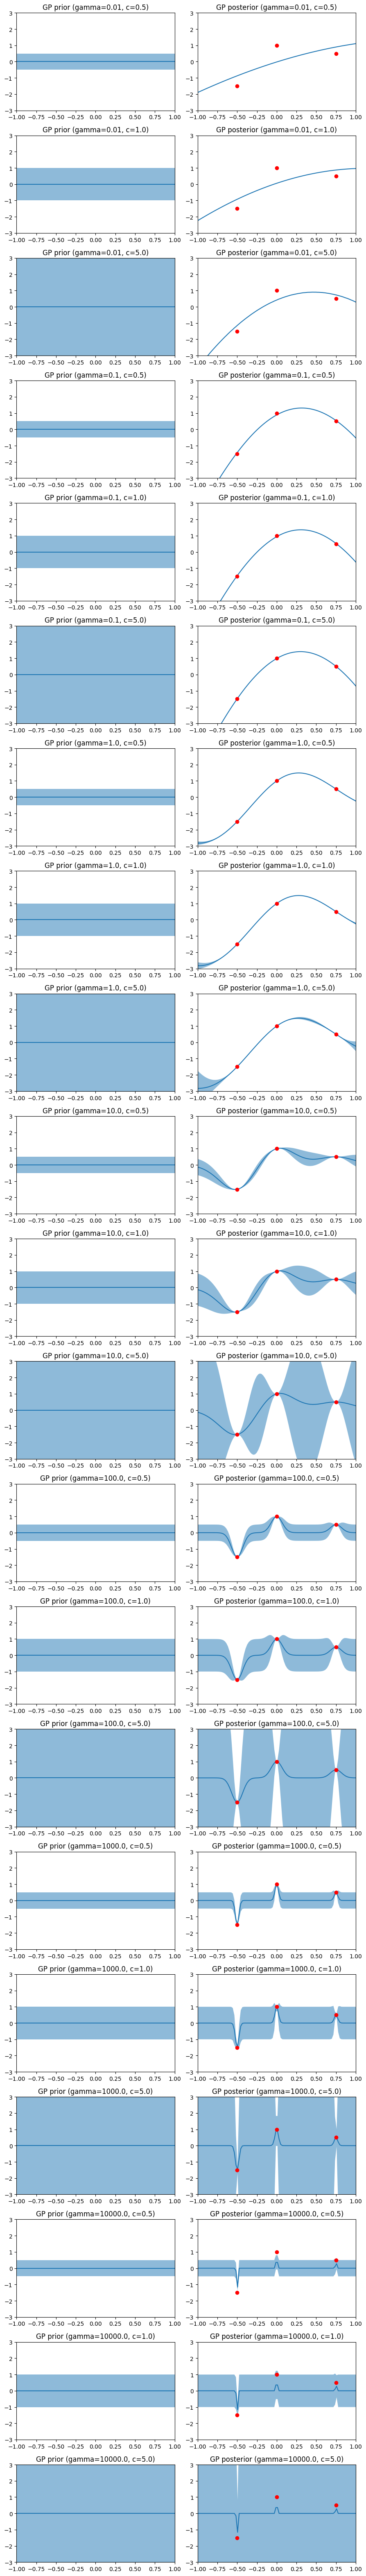

In [3]:
SEED = 42
np.random.seed(SEED)

# Variância observacional
s2 = 1e-4 

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma > 0)
    assert(c > 0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp() * c

x = torch.linspace(-1, 1, 100)[:, None]
xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=0.01, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)
    
    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

# Lista de gammas e cs para avaliação
gammas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cs = [0.5, 1.0, 5.0]

fig, axs = plt.subplots(len(gammas)*len(cs), 2, figsize=(9, len(gammas)*len(cs)*3))

row = 0
for gamma in gammas:
    for c in cs:
        K = rbf_kernel(x, x, gamma, c) + torch.eye(x.shape[0])*s2
        mu = torch.zeros_like(x)

        axs[row, 0].plot(x, mu)
        axs[row, 0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
        axs[row, 0].set_xlim([-1, 1])
        axs[row, 0].set_ylim([-3, 3])
        axs[row, 0].set_title(f'GP prior (gamma={gamma}, c={c})')

        post_mu, post_cov = posterior_pred(x, xtrain, ytrain, gamma, c)
        axs[row, 1].plot(x, post_mu)
        axs[row, 1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
        axs[row, 1].scatter(xtrain, ytrain, color='red', zorder=5)

        axs[row, 1].set_xlim([-1, 1])
        axs[row, 1].set_ylim([-3, 3])
        axs[row, 1].set_title(f'GP posterior (gamma={gamma}, c={c})')

        row += 1

plt.tight_layout()
plt.show()

Alterando os parâmetros de $\gamma$ e $c$, é possível notar que o gráfico da GP prior será afetada apenas por $c$, onde aumentar esse valor aumenta a amplitude da função de covariância, enquanto que diminuir $c$ irá diminuí-lo.

Agora, analisando o gráfico da posterior, é possível ver que aumentar $\gamma$ irá deixar a função de covariância mais ampla, enquanto que diminuir seu valor deixará a função mais estreita. É possível ver isso quando $\gamma=1$. Além disso, é possível ver que, quanto maior for $\gamma$, mais próxima a posteriori irá ficar da média 0 da priori. Novamente, se alterarmos apenas o valor de $c$, é possível ver que o desvio-padrão será alterado, aumentando se incrementarmos o valor de $c$ ou regredindo se diminuirmos. Abaixo, é possível perceber que, a menos que o valor de $\gamma$ seja muito extremo ($\gamma = 100000$ ou $\gamma = 0.01$ por exemplo), os pontos de treino são bem interpolados pelo modelo quase toda vez.

Em resumo, é possível ver que, aumentando muito o valor de $\gamma$, a posteriori fica mais suave e com menos flutuações, enquanto que, deixando $\gamma$ menor que 1, o desvio-padrão não é mais notável pelo gráfico. Pode ser perceber também que para valores radicalmente altos ou baixos, a média deixa de aproximar-se das observações.

**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [4]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [6]:
# Converter dados para tensores PyTorch
train_X_torch = torch.from_numpy(train_X).float()
train_y_torch = torch.from_numpy(train_y).float()
test_X_torch = torch.from_numpy(test_X).float()
test_y_torch = torch.from_numpy(test_y).float()

# Definir a priori do GP
def plot_gp_prior(x, s2=1e-2, gamma=10.0, c=1.0):
    K = rbf_kernel(x, x, gamma, c) + torch.eye(x.shape[0]) * s2
    mu = torch.zeros_like(x)

    plt.plot(x, mu)
    plt.fill_between(x.flatten(), mu.flatten() - K.diag(), mu.flatten() + K.diag(), alpha=0.5)
    plt.xlim([-1, 1])
    plt.ylim([-3, 3])
    plt.title('GP prior')

# Definir a posteriori do GP
def plot_gp_posterior(x, xt, yt, gamma=10.0, c=1.0):
    post_mu, post_cov = posterior_pred(x, xt, yt, gamma, c)
    
    plt.plot(x, post_mu)
    plt.fill_between(x.flatten(), post_mu.flatten() - post_cov.diag(), post_mu.flatten() + post_cov.diag(), alpha=0.5)
    plt.scatter(xt, yt, color='red', zorder=5)
    plt.xlim([-1, 1])
    plt.ylim([-3, 3])
    plt.title('GP posterior')

#def loss_fn(y, K):
#            alpha = torch.linalg.solve(K, y)
#            return 0.5 * y.T @ alpha + 0.5 * torch.logdet(K) + 0.5 * len(y) * np.log(2 * np.pi)    
    

In [7]:
# # Lista de valores iniciais para gamma e c
# gamma = torch.tensor(10.0, requires_grad=True)
# c = torch.tensor(1.0, requires_grad=True)

# # Otimizador
# optimizer = torch.optim.Adam([gamma, c], lr=0.01)


# # Loop de treinamento
# for i in range(1000):
#     optimizer.zero_grad()
#     k = rbf_kernel(train_X_torch, train_X_torch, gamma=gamma, c=c)
#     loss = 0.5 * torch.logdet(k + s2 * torch.eye(len(train_X_torch))) + 0.5 * train_y_torch.T @ torch.inverse(k + s2 * torch.eye(len(train_X_torch))) @ train_y_torch
#     loss.backward()
#     optimizer.step()

#     #if (i+1) % 10 == 0:
#     #    print(f'Iteração {i+1}, Loss: {loss.item()}')

# # Imprimir os valores finais de gamma e c
# print(f'Log verossimilhança final: {loss.item()}')
# print(f'Valor final de gamma: {gamma.item()}')
# print(f'Valor final de c: {c.item()}')
# mu_posteriori, cov_posteriori = posterior_pred(test_X_torch, train_X_torch, train_y_torch, gamma.item(), c.item())
# mse_mean = mean_squared_error(mu_posteriori,test_y_torch)
# #print(f'MSE com relação à media:{mse_mean.item()}')

# # Plotar a posteriori do GP com os parâmetros aprendidos
# fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# plt.sca(axs[0])
# plot_gp_prior(x, gamma=gamma.item(), c=c.item())

# plt.sca(axs[1])
# plot_gp_posterior(x, train_X_torch, train_y_torch, gamma=gamma.item(), c=c.item())

# plt.show()

In [8]:
c = torch.tensor(1.0, requires_grad=True)
gamma = torch.tensor(10.0, requires_grad=True)

optimizer = torch.optim.Adam([c, gamma], lr=0.01)

train_X_ = torch.tensor(train_X)
train_y_ = torch.tensor(train_y)

T = 5000
s2 = 0.01

for t in range(T):
    k = rbf_kernel(train_X_, train_X_, gamma=gamma, c=c)
    loss = 0.5 * torch.logdet(k + s2 * torch.eye(len(train_X_))) + 0.5 * train_y_.T @ torch.inverse(k + s2 * torch.eye(len(train_X_))) @ train_y_
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print('Log-verossimilhança:', -loss.item())
print(f'Valor final de gamma: {gamma.item()}')
print(f'Valor final de c: {c.item()}')

def mse_torch(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

test_X_ = torch.tensor(test_X)
test_y_ = torch.tensor(test_y)
post_mu, post_cov = posterior_pred(test_X_, train_X_, train_y_, gamma.item(), c.item())
mse_mean = mse_torch(post_mu, test_X_)

print("MSE (médio):\t", mse_mean.item())

Log-verossimilhança: 150.3929847865046
Valor final de gamma: 19.097808837890625
Valor final de c: 0.19747710227966309
MSE (médio):	 0.6228722551811713


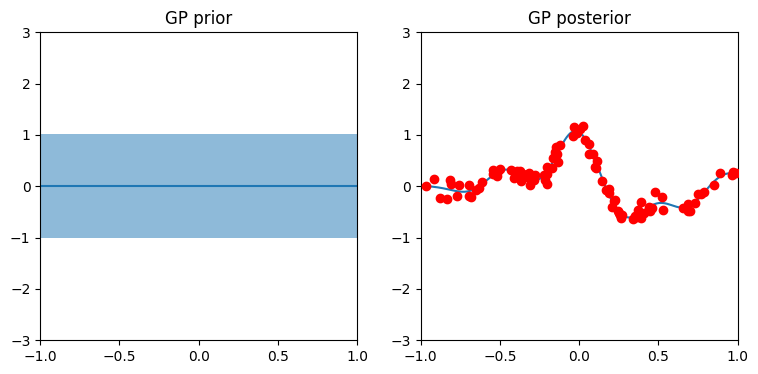

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

mu = torch.zeros_like(test_X_torch)
K = rbf_kernel(test_X_torch, test_X_torch) + torch.eye(test_X_torch.shape[0])*s2

axs[0].plot(test_X_torch, mu)
axs[0].fill_between(test_X_torch.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


axs[1].plot(test_X_torch, post_mu)
axs[1].fill_between(test_X_torch.flatten(), post_mu.flatten() - post_cov.diag(), post_mu.flatten() + post_cov.diag(), alpha=0.5)
axs[1].scatter(train_X_torch, train_y_torch, color="red", zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title("GP posterior")
plt.show()

# Exercício de "papel e caneta"

**1.** Na nota de aula, derivamos a posteriori preditiva $p(y_\star | x_\star, x_1, y_1, \ldots, x_N, y_N)$. Por simplicidade, deduzimos a priori preditiva $p(y_\star, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N)$ e as condicionamos nas saídas $y_1, \ldots, y_N$ observadas no conjunto de treino. No entanto, também é possível obter o mesmo resultado calculando a posteriori $p(f_\star, f_1, \ldots, f_N | x_\star, x_1, \ldots, x_N)$ e, então, calculando o valor esperado de $p(y_\star | x_\star, f_\star)$ sob essa posteriori. Deduza novamente a posteriori preditiva seguindo esse outro procedimento.

a) Seja $X = (x_i)_{1\leq i \leq n}, \ y = (y_i)_{1\leq i \leq n}$ e $f = (f(x_i))_{1\leq i \leq n}$. Vamos então ver que $p(y^*|X,y,x^*) = \int \int p(y^*|f^*, x^*)p(f^*,f|X,x^*,y)dfdf^*$, onde $f^*=f(x^*)$.

Levando em consideração que cada observação $y_i$ é modelada como uma função $f(x_i)$ com a adição de um ruído de variância $\sigma^2$, podemos escrever a posteriori preditiva como $p(y^* | X, y, x^*) = \int p(y^* | f^*) p(f^* | X, y, x^*) df^*$. 

$p(y^* | f^*)$ será a verossimilhança do modelo de regressão gaussiano, e é igual a $\mathcal{N}(y^* | f^*, \sigma^2)$, que é a distribuição gaussiana com média $f^*$ e variância $\sigma^2$.

$p(f^* | X, y, x^*)$ é a distribuição a posteriori da função no novo ponto de entrada $x^*$, dado o conjunto de treinamento $(X, y)$. Essa distribuição pode ser encontrada aplicando o teorema de Bayes:

$p(f^* | X, y, x^*) = p(X, y, x^* | f^*) p(f^*) / p(X, y, x^*)$. Substituindo na integral original, teremos a distribuição a posteriori preditiva:

$$p(y^* | X, y, x^*) = \int \mathcal{N}(y^* | f^*, \sigma^2) * \left[p(X, y, x^* | f^*) p(f^*) / p(X, y, x^*)\right] df^*.$$

b) Agora, seja $K = \begin{bmatrix}
k(X,X) & k(X,x^*)\\
k(X,x^*)^T & k(x^*,x^*)
\end{bmatrix}$
o kernel do processo gaussiano.Vamos verificar que, se $A=k(X,X)$, $b=k(X,x^*)$ e $c=k(x^*,x^*)$, então

$$K^{-1}= \begin{bmatrix}
A^{-1}[I+mbb^TA^{-1}] & -mA^{-1}b\\
-mb^TA^{-1} & m
\end{bmatrix},$$ onde $m= \dfrac{1}{c-b^TA^{-1}b}$.

Escrevendo $K$ em blocos de forma generalizada, temos $K = \begin{bmatrix} A & B \\ C & D \end{bmatrix}$, então $K^{-1} = \begin{bmatrix} (A-BD^{-1}C)^{-1} & -A^{-1}B(D-CA^{-1}B)^{-1} \\ -D^{-1}C(A-BD^{-1}C)^{-1} & (D-CA^{-1}B)^{-1} \end{bmatrix}$

Dado que $A = k(X,X)$, $B = k(X,x^*) = b$, $C = B^T = k(X,x^*)^T = b^T$ e $D = k(x^*,x^*) = c$, podemos substituir esses valores na matriz acima:

$$K^{-1} = \begin{bmatrix} (A - bb^Tc^{-1})^{-1} & -A^{-1}b(c-b^TA^{-1}b)^{-1} \\ -c^{-1}b^T(A - bb^Tc^{-1})^{-1} & (c - b^TA^{-1}b)^{-1} \end{bmatrix}$$

Agora, usando que $m = \dfrac{1}{c - b^TA^{-1}b}$, podemos simplificar $K^{-1}$:

$$K^{-1} = \begin{bmatrix} A^{-1} + m A^{-1}bb^TA^{-1} & -m A^{-1}b \\ -m b^TA^{-1} & m \end{bmatrix},$$

que é o valor que queríamos chegar.

c) Aqui, vamos mostrar que 

$p(f^*, f | X, x^*, y)$ satisfaz $p(f^*, f | X, x^*, y  \propto p(y)|X, x^*) · p(f, f^* | X, x^*)  \propto exp\{-\dfrac{(f^T -M^{-1}v)^T M (f-M^{-1}v)}{2}\}.exp\{-\dfrac{K_{22}(f^*)^2-v^TM^{-1}v}{2}\},$ onde $K_{22}=m, \ M = (K_{11} + \sigma^{-2}I_N ), I_N$ é a matriz identidade de tamanho $N$ e $v = \sigma^{-2}y +f^*K_{12}$, sabendo que $K_{12}=-mA^{-1}b $, e vamos concluir que 

$$p(y^*|X, y, x^*) \propto \int p(y^*|x^*, f^*)exp\{-\dfrac{K_{22}(f^*)^2-v^TM^{-1}v}{2}\} df^*.$$

Assim, usando a posteriori conjunta

$$p(f^*, f | X, x^*, y) \propto p(y|f, X) \cdot p(f, f^* | X, x^*),$$

onde $p(y|f, X)$ é a verossimilhança e $p(f, f^* | X, x^*)$ é a priori conjunta, assumindo que $y = f + \epsilon$, onde $\epsilon$ é o ruído com variância $\sigma^2$, então $p(y|f, X)$ será uma distribuição gaussiana com média $f$ e variância $\sigma^2$. Para a priori, assumindo um processo gaussiano, então $p(f, f^* | X, x^*)$ também é uma distribuição gaussiana multivariada, cuja covariância é dada pela matriz do kernel $K$.

Assim, podemos escrever a posteriori como:

$$p(f^*, f | X, x^*, y) \propto  \text{exp}\{-\dfrac{1}{2\sigma^2}(y - f)^T(y - f)\} \cdot \text{exp}\{-\dfrac{1}{2}(f, f^*)^T K^{-1} (f, f^*)\}.$$

Substituindo a inversa da matriz $K$ que encontramos anteriormente, obtemos:

$p(f^*, f | X, x^*, y) \propto \text{exp}\{-\dfrac{(f^T -M^{-1}v)^T M (f-M^{-1}v)}{2}\}\text{exp}\{-\dfrac{K_{22}(f^*)^2-v^TM^{-1}v}{2}\}$.

Finalmente, para obter a distribuição posteriori preditiva $p(y^*|X, y, x^*)$, integramos sobre as possíveis funções $f^*$:

$$p(y^*|X, y, x^*) \propto \int p(y^*|x^*, f^*) \text{exp} \{-\dfrac{K_{22}(f^*)^2-v^TM^{-1}v}{2}\} df^*,$$

sendo essa a nossa conclusão desejada.

d) Agora, mostraremos que $p(y^* | x^*, f^*) \text{exp}\{-\dfrac{K_{22}(f^*)^2 - v^TM^{-1}v}{2}\} \propto \text{exp}\{-\dfrac{\alpha(f^*-\alpha^{-1}\beta)^2}{2}\}\text{exp}\{-\dfrac{\sigma^{-2}(y^*)^2-\alpha^{-1}\beta^2}{2}\}$,

onde $\alpha = K_{22}-K_{12}^TM^{-1}K_{12}+\sigma^{-2}$ e $\beta = \sigma^{-2}y^*-\sigma^{-2}y^TM^{-1}K_{12}$.

Primeiro, vamos reescrever a expressão original dada:

$$p(y^* | x^*, f^*) \text{exp}\{-\dfrac{K_{22}(f^*)^2 - v^TM^{-1}v}{2}\}.$$

Substituindo as expressões para $v, \ K_{22}$ e $K_{12}$ na equação acima, temos:

$$\text{exp}\{-\dfrac{m(f^*)^2 - [\sigma^{-2}y + f^*(-mA^{-1}b)]^T (K_{11} + \sigma^{-2}I_N)^{-1}[\sigma^{-2}y + f^*(-mA^{-1}b)]}{2}\}.$$

Agora, reescrevendo $\alpha$ e $\beta$:

$$\alpha = m + b^TA^{-1}b$$


$$\beta = \sigma^{-2}y + mA^{-1}b$$

Substituindo $\alpha$ e $\beta$ na equação, podemos reescrever a expressão como:

$$\text{exp}\{-\dfrac{(\alpha f^* - \beta)^2}{2\alpha}\}.$$

Para o termo restante:

$$\text{exp}\{-\dfrac{\sigma^{-2}(y^*)^2-\alpha^{-1}\beta^2}{2}\}.$$

Juntando as expressões, temos:

$$\text{exp}\{-\dfrac{(\alpha f^* - \beta)^2}{2\alpha}\}\text{exp}\{-\dfrac{\sigma^{-2}(y^*)^2-\alpha^{-1}\beta^2}{2}\},$$

o que é proporcional a

$$\text{exp}\{-\dfrac{\alpha(f^*-\alpha^{-1}\beta)^2}{2}\} \text{exp}\{-\dfrac{\sigma^{-2}(y^*)^2-\alpha^{-1}\beta^2}{2}\}.$$

OBS: exercício feito seguindo as instruções passadas para a solução da questão.

**2.** Quando trocamos a verossimilhança Gaussiana por uma Bernoulli (i.e., no caso de classificação binária), a posteriori para nosso GP não possui fórmula fechada. Mais especificamente, a verossimilhança para esse modelo é dada por $y | x \sim \text{Ber}(\sigma(f(x))$ onde $\sigma$ é a função sigmoide. Em resposta à falta de uma solução analítica, podemos aproximar a posteriori sobre $f$ para qualquer conjunto de pontos de entrada usando as técnicas de inferência aproximada que vimos anteriormente. Discuta como usar a aproximação de laplace nesse caso, incluindo as fórmulas para os termos da Hessiana. Além disse, discuta como usar o resultado desse procedimento para aproximar a posteriori preditiva.

Supondo que temos um conjunto de dados $D = \{(x_i, y_i)\}, i = 1, \ldots, N$, e assumindo a verossimilhança dada por $p(y|f)$, onde $f$ é um vetor de função latente $f = [f(x_1), ..., f(x_N)]^T$, temos que a posteriori $p(f|y) = p(y|f)p(f)/p(y)$ não é Gaussiana porque sua verossimilhança não é Gaussiana, então não é possível derivar uma solução analítica para ela.

No caso de utilizarmos uma distribuição de Bernoulli, dada por $p(y|f) = \prod_{i=1}^m p(y_i|f_i)$, podemos utilizar o MAP e então aproximar a distribuição a posteriori por uma Gaussiana multivariada centrada no ponto de MAP. Isso pode ser feito aproximando a log-verossimilhança por uma função quadrática em torno desse ponto, transformando a posteriori numa Gaussiana.

A aproximação de Laplace será dada da seguinte maneira:

$$ log p(y|f) \approx log p(y|P_{MAP}) + 0.5 * (f - P_{MAP})^T * H * (f - P_{MAP}), $$

onde $H$ é a Hessiana da log-verossimilhança no $P_{MAP}$. Os termos da Hessiana são dados por:

$$H_{ij} = -\dfrac{\partial^2 log p(y|P_{MAP})}{\partial f_i\partial f_j}$$

No caso da verossimilhança de uma Bernoulli, a Hessiana é dada por:

$$H_{ii} = \sigma(P_{MAP}[i]) * (1 - \sigma(P_{MAP}[i])), $$

onde $\sigma$ é a função sigmoide. Assim, usando a aproximação de Laplace para a posteriori, temos:

$$p(f|y) \approx q(f) = \mathcal{N}(f|P_{MAP}, H^{-1})$$

Assim, a posteriori preditiva $p(y^*|x^*, y)$ pode ser aproximada integrando a verossimilhança $p(y^*|f^*)$ sobre a distribuição a posteriori de $f*$:

$$p(y^*|x^*, y) = \int p(y^*|f^*) q(f^*) df^*$$